In [1]:
import pandas as pd

# Load the data
df = pd.read_table('data/Test01_wrist.txt', skiprows=30, header=0, sep=';')


In [2]:
df['DATE/TIME'] = pd.to_datetime(
    df['DATE/TIME'],
    format='%d/%m/%Y %H:%M:%S',
    errors='coerce' ,   # optional, helps catch mismatches
    utc=False
).dt.tz_localize('Europe/Berlin', nonexistent='shift_forward', ambiguous='NaT')

df['DATE'] = df['DATE/TIME'].dt.date
df['TIME'] = df['DATE/TIME'].dt.time
df['HOUR'] = df['DATE/TIME'].dt.hour + df['DATE/TIME'].dt.minute / 60 + df['DATE/TIME'].dt.second / 3600
# show just to 2 decimal time
df['HOUR'] = df['HOUR'].round(2)

In [3]:
# Filter data for two consecutive days from 12:00 to 12:00
from datetime import date, time, datetime

# Define the two consecutive days
day1 = pd.to_datetime("2024-01-17").date()
day2 = pd.to_datetime("2024-01-18").date()

# Get data for both days
df_day1 = df[df['DATE'] == day1].copy()
df_day2 = df[df['DATE'] == day2].copy()

# Filter day1 from 12:00 onwards (HOUR >= 12)
df_day1_filtered = df_day1[df_day1['HOUR'] >= 12.0].copy()

# Filter day2 until 12:00 (HOUR < 12)
df_day2_filtered = df_day2[df_day2['HOUR'] < 12.0].copy()

# Adjust time axis: 
# - Day1 hours: keep as is (12.0 to ~24.0)
# - Day2 hours: add 24 to shift them to the next day (24.0 to ~36.0)
df_day2_filtered['HOUR_ADJUSTED'] = df_day2_filtered['HOUR'] + 24

# Add the adjusted hour column to day1 data as well
df_day1_filtered['HOUR_ADJUSTED'] = df_day1_filtered['HOUR']

# Combine both datasets
df_two_days = pd.concat([df_day1_filtered, df_day2_filtered], ignore_index=True)

# Sort by adjusted hour to ensure proper chronological order
df_two_days = df_two_days.sort_values('HOUR_ADJUSTED').reset_index(drop=True)

print(f"Day 1 ({day1}) data points (12:00-24:00): {len(df_day1_filtered)}")
print(f"Day 2 ({day2}) data points (00:00-12:00): {len(df_day2_filtered)}")
print(f"Combined dataset: {len(df_two_days)} points")
print(f"Time range: {df_two_days['HOUR_ADJUSTED'].min():.2f} to {df_two_days['HOUR_ADJUSTED'].max():.2f}")

print("\nFirst few rows:")
print(df_two_days[['DATE', 'HOUR', 'HOUR_ADJUSTED', 'STATE', 'PIMn', 'CLEAR']].head())

print("\nLast few rows:")
print(df_two_days[['DATE', 'HOUR', 'HOUR_ADJUSTED', 'STATE', 'PIMn', 'CLEAR']].tail())

Day 1 (2024-01-17) data points (12:00-24:00): 720
Day 2 (2024-01-18) data points (00:00-12:00): 720
Combined dataset: 1440 points
Time range: 12.01 to 35.99

First few rows:
         DATE   HOUR  HOUR_ADJUSTED  STATE      PIMn  CLEAR
0  2024-01-17  12.01          12.01      0  105.3170   0.19
1  2024-01-17  12.03          12.03      0   99.0500   0.21
2  2024-01-17  12.04          12.04      0  126.7830   0.15
3  2024-01-17  12.06          12.06      0   65.1667   0.16
4  2024-01-17  12.08          12.08      0   70.0167   0.17

Last few rows:
            DATE   HOUR  HOUR_ADJUSTED  STATE      PIMn  CLEAR
1435  2024-01-18  11.93          35.93      0   29.0667   0.06
1436  2024-01-18  11.94          35.94      0   21.6167   0.09
1437  2024-01-18  11.96          35.96      0  100.6330   0.05
1438  2024-01-18  11.98          35.98      0   85.6000   0.07
1439  2024-01-18  11.99          35.99      0   55.6167   0.09


Day 1 (2024-01-17) data points (12:00-24:00): 720
Day 2 (2024-01-18) data points (00:00-12:00): 720
Combined dataset: 1440 points
Time range: 12.01 to 35.99

First few rows:
         DATE   HOUR  HOUR_ADJUSTED  STATE      PIMn  MELANOPIC EDI
0  2024-01-17  12.01          12.01      0  105.3170         235.85
1  2024-01-17  12.03          12.03      0   99.0500         273.00
2  2024-01-17  12.04          12.04      0  126.7830         158.25
3  2024-01-17  12.06          12.06      0   65.1667         183.68
4  2024-01-17  12.08          12.08      0   70.0167         190.35

Last few rows:
            DATE   HOUR  HOUR_ADJUSTED  STATE      PIMn  MELANOPIC EDI
1435  2024-01-18  11.93          35.93      0   29.0667          77.19
1436  2024-01-18  11.94          35.94      0   21.6167         123.50
1437  2024-01-18  11.96          35.96      0  100.6330          61.19
1438  2024-01-18  11.98          35.98      0   85.6000          88.51
1439  2024-01-18  11.99          35.99      0  

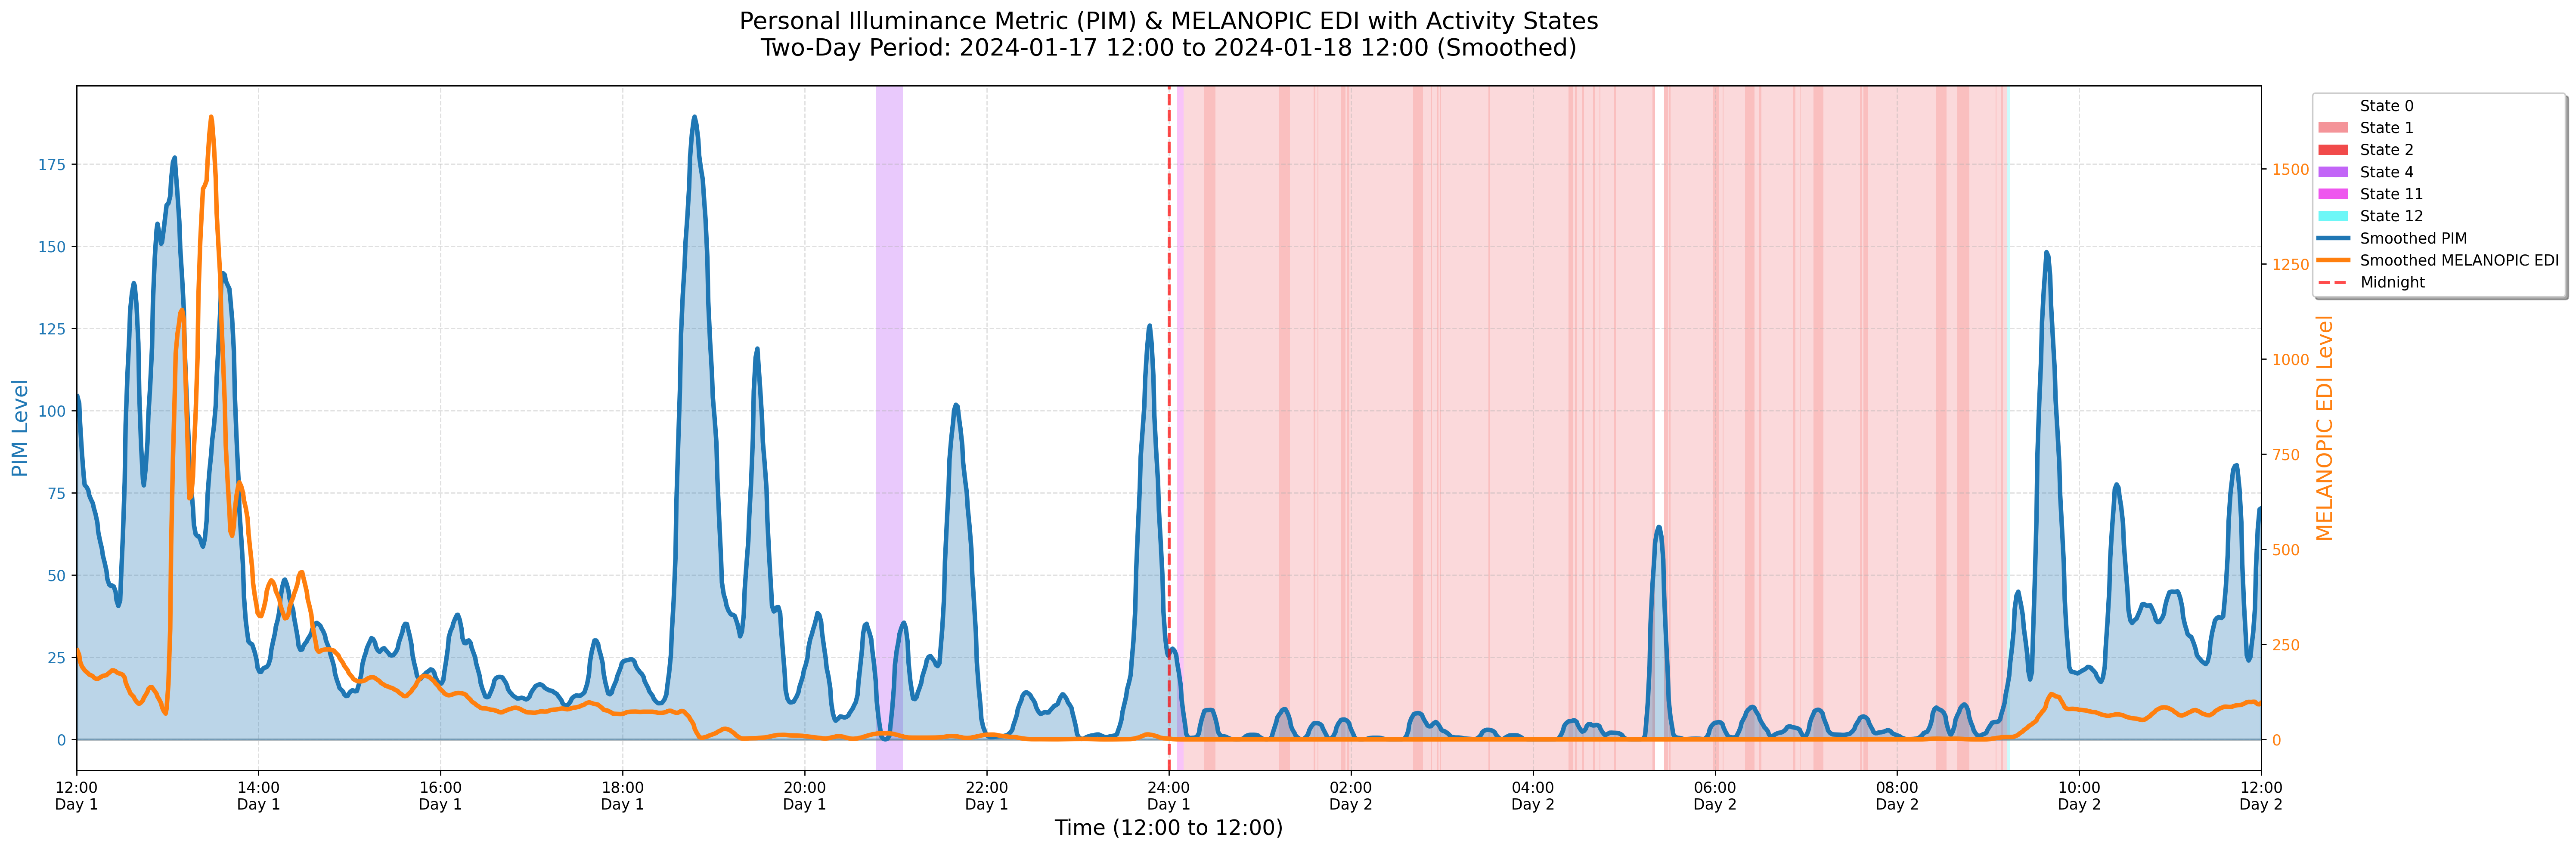

In [4]:
# --- Plot PIM vs. MELANOPIC EDI from 12:00 day1 to 12:00 day2 with activity-state shading and filled PIMn area ---

import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from matplotlib.patches import Patch

# ---------------------------------------------------------------------
# Assumptions:
# - DataFrame `df` already exists with columns:
#   'DATE' (date or datetime), 'HOUR' (float hour-of-day), 'STATE' (int),
#   'PIMn' (float), 'MELANOPIC EDI' (float)  # note the space
# - If DATE is datetime, we'll convert to date below.
# ---------------------------------------------------------------------

# Ensure DATE is a date (not datetime)
if np.issubdtype(pd.Series(df['DATE']).dtype, np.datetime64):
    df['DATE'] = pd.to_datetime(df['DATE']).dt.date
else:
    # If DATE might be a string, try to parse
    if df['DATE'].dtype == object:
        try:
            df['DATE'] = pd.to_datetime(df['DATE']).dt.date
        except Exception:
            pass  # keep as-is if already date-like

# Safety check for required columns
required_cols = {'DATE', 'HOUR', 'STATE', 'PIMn', 'MELANOPIC EDI'}
missing = required_cols.difference(df.columns)
if missing:
    raise ValueError(f"Missing required columns in df: {missing}")

# --- Define the two consecutive days ---
day1 = pd.to_datetime("2024-01-17").date()
day2 = pd.to_datetime("2024-01-18").date()

# --- Get data for both days ---
df_day1 = df[df['DATE'] == day1].copy()
df_day2 = df[df['DATE'] == day2].copy()

# --- Filter windows: day1 from 12:00 to 24:00; day2 from 00:00 to 12:00 ---
df_day1_filtered = df_day1[df_day1['HOUR'] >= 12.0].copy()
df_day2_filtered = df_day2[df_day2['HOUR'] < 12.0].copy()

# --- Adjust hour axis: shift day2 by +24h ---
df_day1_filtered['HOUR_ADJUSTED'] = df_day1_filtered['HOUR']
df_day2_filtered['HOUR_ADJUSTED'] = df_day2_filtered['HOUR'] + 24.0

# --- Combine and sort ---
df_two_days = pd.concat([df_day1_filtered, df_day2_filtered], ignore_index=True)
df_two_days = df_two_days.sort_values('HOUR_ADJUSTED').reset_index(drop=True)

# --- Info prints ---
print(f"Day 1 ({day1}) data points (12:00-24:00): {len(df_day1_filtered)}")
print(f"Day 2 ({day2}) data points (00:00-12:00): {len(df_day2_filtered)}")
print(f"Combined dataset: {len(df_two_days)} points")
if len(df_two_days):
    print(f"Time range: {df_two_days['HOUR_ADJUSTED'].min():.2f} to {df_two_days['HOUR_ADJUSTED'].max():.2f}")
    print("\nFirst few rows:")
    print(df_two_days[['DATE', 'HOUR', 'HOUR_ADJUSTED', 'STATE', 'PIMn', 'MELANOPIC EDI']].head())
    print("\nLast few rows:")
    print(df_two_days[['DATE', 'HOUR', 'HOUR_ADJUSTED', 'STATE', 'PIMn', 'MELANOPIC EDI']].tail())

# --- Colors for activity states ---
state_colors = {
    0: "#ffffff",   # no activity / baseline
    1: "#f49499",   # light activity
    2: "#f14a4a",   # higher activity
    4: "#c265f7",   # sleep?
    11: "#ee57ee",  # nap?
    12: "#6df7f7"   # other state
}

# --- Helper to compute contiguous state periods over the adjusted axis ---
def get_state_periods_two_days(df_):
    periods = []
    if len(df_) == 0:
        return periods
    current_state = df_.iloc[0]['STATE']
    start_hour = df_.iloc[0]['HOUR_ADJUSTED']
    for i in range(1, len(df_)):
        if df_.iloc[i]['STATE'] != current_state:
            periods.append({'state': current_state, 'start': start_hour, 'end': df_.iloc[i]['HOUR_ADJUSTED']})
            current_state = df_.iloc[i]['STATE']
            start_hour = df_.iloc[i]['HOUR_ADJUSTED']
    # close final period
    periods.append({'state': current_state, 'start': start_hour, 'end': df_.iloc[-1]['HOUR_ADJUSTED']})
    return periods

# --- Smooth signals ---
window_size = 10
# PIMn smoothing
pim_ma_2day = df_two_days['PIMn'].rolling(window=window_size, center=True).mean()
pim_smooth_2day = gaussian_filter1d(pim_ma_2day.fillna(df_two_days['PIMn']).to_numpy(), sigma=1.5)

# MELANOPIC EDI smoothing
mel_ma_2day = df_two_days['MELANOPIC EDI'].rolling(window=window_size, center=True).mean()
mel_smooth_2day = gaussian_filter1d(mel_ma_2day.fillna(df_two_days['MELANOPIC EDI']).to_numpy(), sigma=1.5)

# --- Plotting ---
fig, ax1 = plt.subplots(figsize=(24, 8), dpi=250)

# background shading by STATE
periods = get_state_periods_two_days(df_two_days)
for period in periods:
    state = period['state']
    if state in state_colors:
        ax1.axvspan(period['start'], period['end'], facecolor=state_colors[state], alpha=0.35, zorder=0)

# Left y-axis: PIMn (line + filled area beneath with same color)
(line1,) = ax1.plot(
    df_two_days['HOUR_ADJUSTED'], pim_smooth_2day,
    color='#1f77b4', linewidth=3, label='Smoothed PIM', zorder=3
)
ax1.fill_between(
    df_two_days['HOUR_ADJUSTED'], pim_smooth_2day,
    color=line1.get_color(), alpha=0.30, zorder=2
)

ax1.set_ylabel("PIM Level", fontsize=14, color='#1f77b4')
ax1.tick_params(axis='y', labelcolor='#1f77b4')

# Right y-axis: MELANOPIC EDI (line only)
ax2 = ax1.twinx()
(line2,) = ax2.plot(
    df_two_days['HOUR_ADJUSTED'], mel_smooth_2day,
    color='#ff7f0e', linewidth=3, label='Smoothed MELANOPIC EDI', zorder=3
)
ax2.set_ylabel("MELANOPIC EDI Level", fontsize=14, color='#ff7f0e')
ax2.tick_params(axis='y', labelcolor='#ff7f0e')

# X-axis setup: 12 -> 36 (12:00 day1 to 12:00 day2)
ax1.set_xlim(12, 36)
xticks = list(range(12, 37, 2))
xtick_labels = []
for tick in xticks:
    if tick <= 24:
        hour = tick
        day_label = "Day 1"
    else:
        hour = tick - 24
        day_label = "Day 2"
    xtick_labels.append(f"{hour:02d}:00\n{day_label}")
ax1.set_xticks(xticks)
ax1.set_xticklabels(xtick_labels, fontsize=10)
ax1.set_xlabel("Time (12:00 to 12:00)", fontsize=14)

# Vertical line at midnight
ax1.axvline(x=24, color='red', linestyle='--', alpha=0.7, linewidth=2, label='Midnight', zorder=4)

# Title
ax1.set_title(
    f"Personal Illuminance Metric (PIM) & MELANOPIC EDI with Activity States\n"
    f"Two-Day Period: {day1} 12:00 to {day2} 12:00 (Smoothed)",
    fontsize=16, pad=20
)

# Grid
ax1.axhline(y=0, color='gray', linestyle='-', alpha=0.5, zorder=1)
ax1.grid(True, linestyle='--', alpha=0.4, zorder=1)

# Legend: states + lines + midnight
legend_elements = []
states_in_data = sorted(df_two_days['STATE'].dropna().unique())
for state in states_in_data:
    if state in state_colors:
        legend_elements.append(Patch(facecolor=state_colors[state], alpha=1, label=f'State {state}'))
legend_elements.extend([line1, line2])
legend_elements.append(plt.Line2D([0], [0], color='red', linestyle='--', alpha=0.7, linewidth=2, label='Midnight'))

ax1.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.02, 1),
           frameon=True, fancybox=True, shadow=True)

plt.tight_layout()
plt.show()


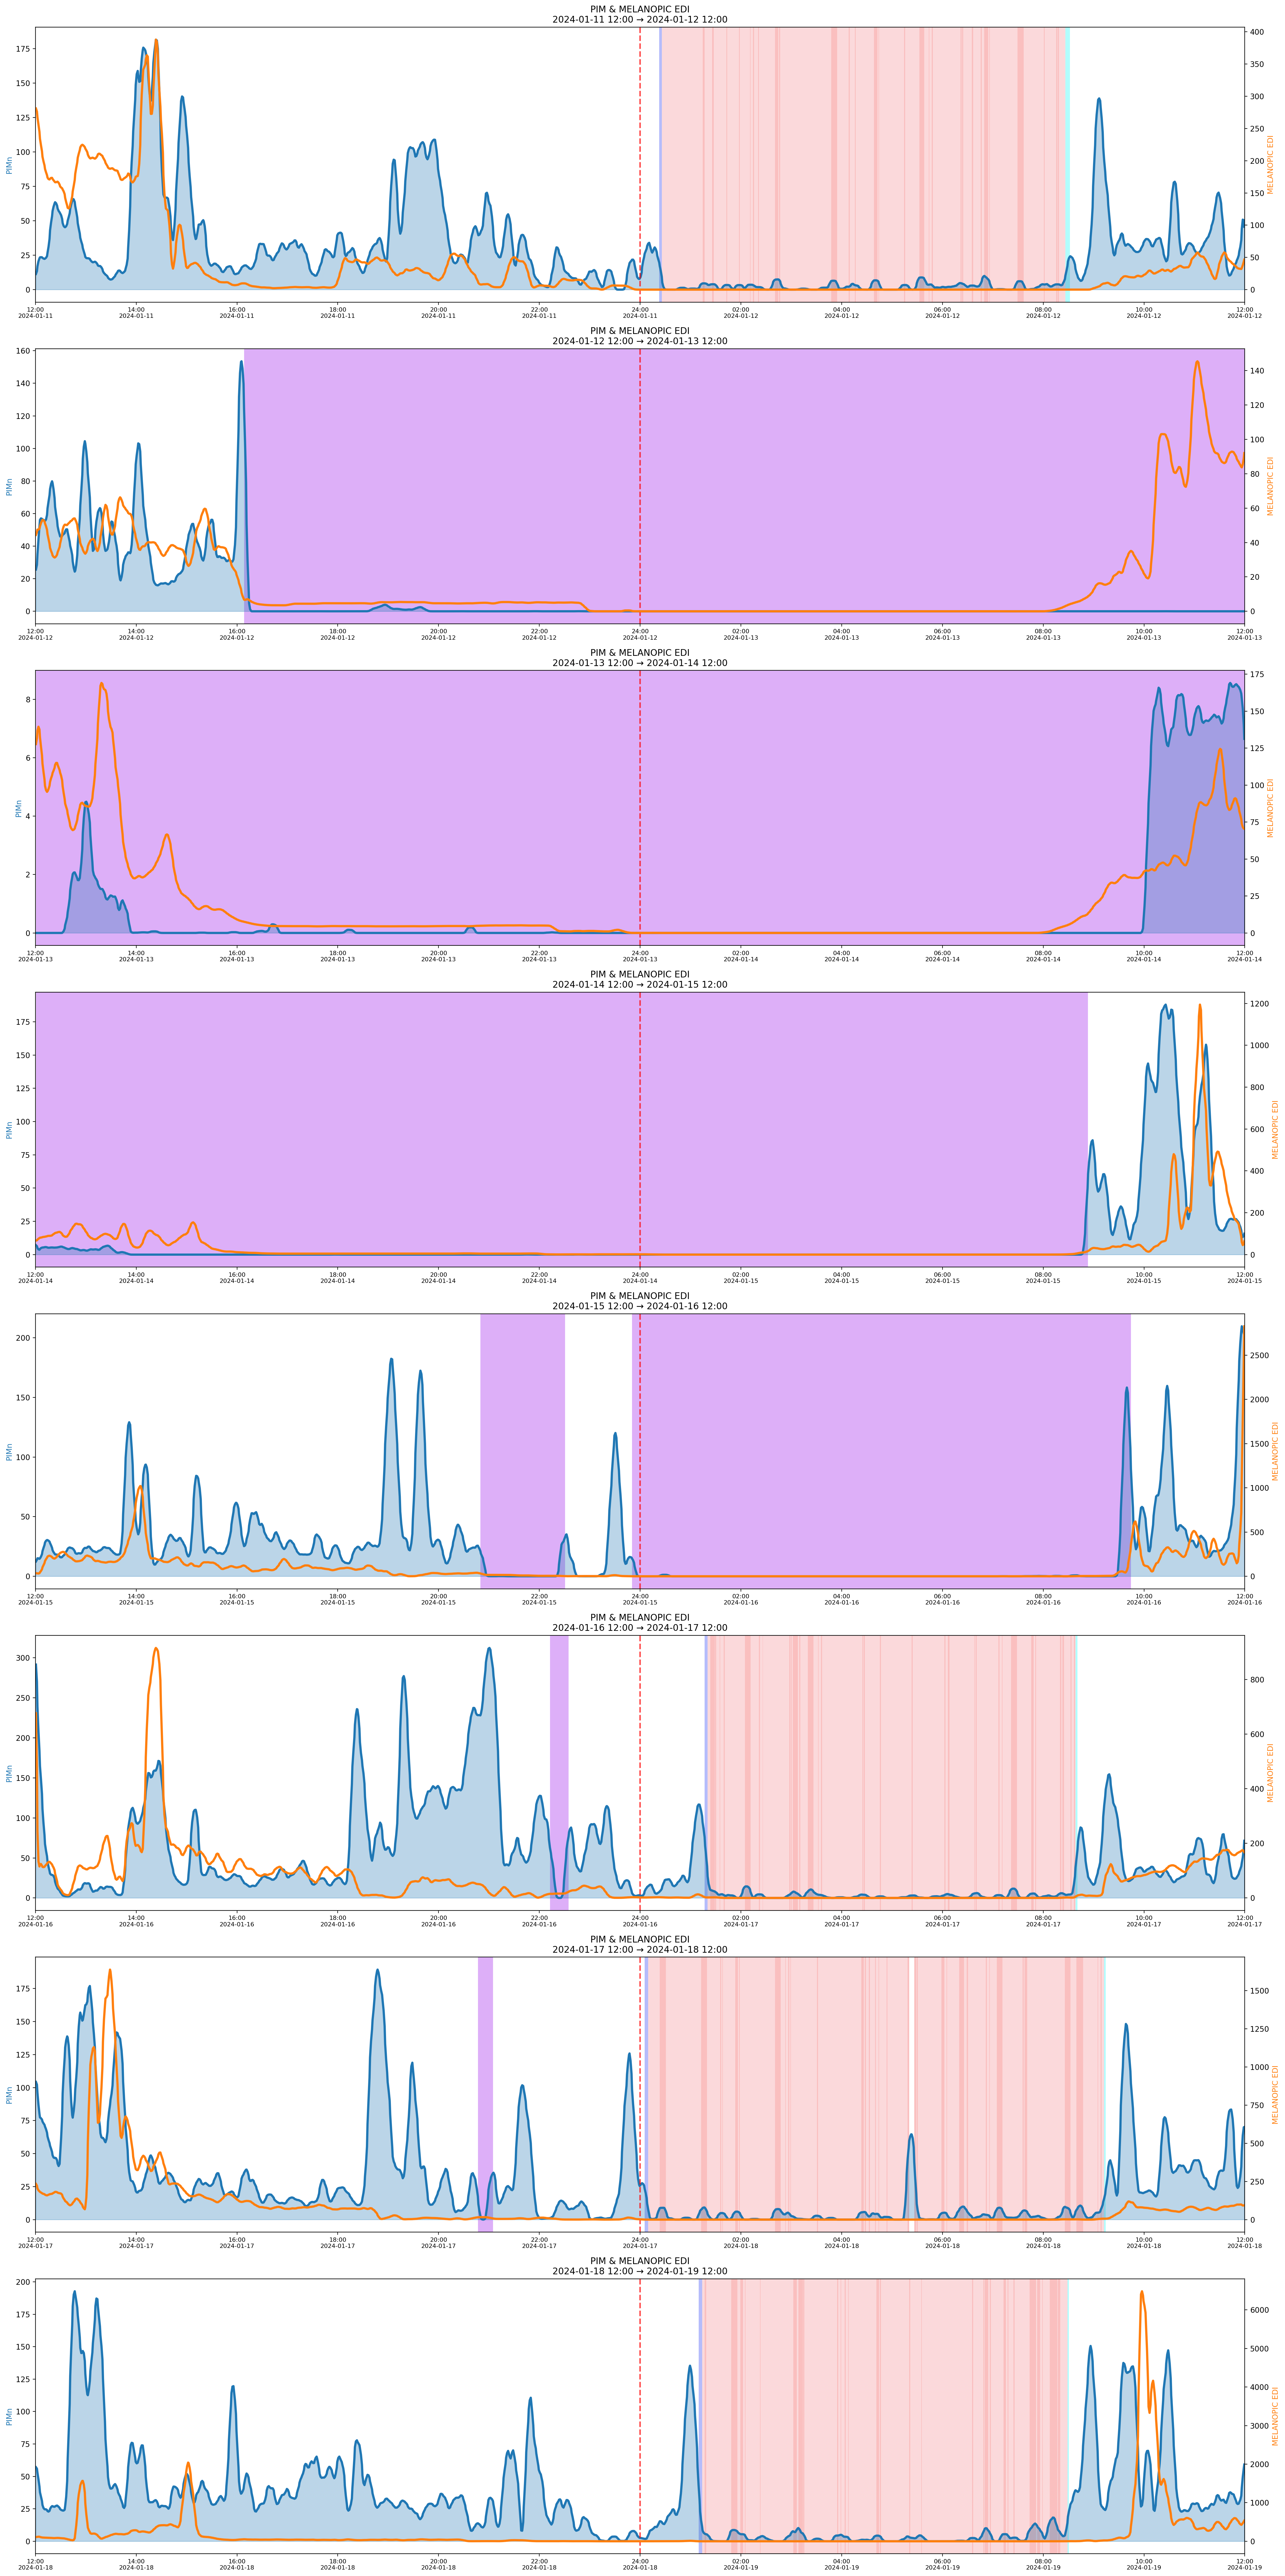

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from matplotlib.patches import Patch

# ---- Function to plot two consecutive days ----
def plot_two_days(df, day1, day2, ax=None):
    # --- filter ---
    df_day1 = df[df['DATE'] == day1].copy()
    df_day2 = df[df['DATE'] == day2].copy()

    df_day1 = df_day1[df_day1['HOUR'] >= 12].copy()
    df_day2 = df_day2[df_day2['HOUR'] < 12].copy()

    df_day1['HOUR_ADJUSTED'] = df_day1['HOUR']
    df_day2['HOUR_ADJUSTED'] = df_day2['HOUR'] + 24

    df_two_days = pd.concat([df_day1, df_day2], ignore_index=True)
    if df_two_days.empty:
        return None  # skip if no data

    # --- smoothing ---
    window_size = 10
    pim_ma = df_two_days['PIMn'].rolling(window=window_size, center=True).mean()
    pim_smooth = gaussian_filter1d(pim_ma.fillna(df_two_days['PIMn']).to_numpy(), sigma=1.5)

    mel_ma = df_two_days['MELANOPIC EDI'].rolling(window=window_size, center=True).mean()
    mel_smooth = gaussian_filter1d(mel_ma.fillna(df_two_days['MELANOPIC EDI']).to_numpy(), sigma=1.5)

    # --- state shading ---
    state_colors = {0:"#ffffff", 1:"#f49499", 2:"#f14a4a", 4:"#a01cec", 11:"#2d41f5", 12:"#1efbfb"}
    def get_state_periods(df_):
        periods = []
        if len(df_) == 0: return periods
        current = df_.iloc[0]['STATE']
        start = df_.iloc[0]['HOUR_ADJUSTED']
        for i in range(1, len(df_)):
            if df_.iloc[i]['STATE'] != current:
                periods.append({'state': current, 'start': start, 'end': df_.iloc[i]['HOUR_ADJUSTED']})
                current = df_.iloc[i]['STATE']
                start = df_.iloc[i]['HOUR_ADJUSTED']
        periods.append({'state': current, 'start': start, 'end': df_.iloc[-1]['HOUR_ADJUSTED']})
        return periods

    if ax is None:
        fig, ax = plt.subplots(figsize=(24, 8), dpi=250)

    ax2 = ax.twinx()

    for period in get_state_periods(df_two_days):
        if period['state'] in state_colors:
            ax.axvspan(period['start'], period['end'], facecolor=state_colors[period['state']], alpha=0.35, zorder=0)

    (line1,) = ax.plot(df_two_days['HOUR_ADJUSTED'], pim_smooth,
                       color='#1f77b4', linewidth=3, label='PIM')
    ax.fill_between(df_two_days['HOUR_ADJUSTED'], pim_smooth,
                    color=line1.get_color(), alpha=0.3)

    (line2,) = ax2.plot(df_two_days['HOUR_ADJUSTED'], mel_smooth,
                        color='#ff7f0e', linewidth=3, label='MELANOPIC EDI')

    # cosmetics
    ax.set_xlim(12, 36)
    xticks = list(range(12, 37, 2))
    labels = []
    for tick in xticks:
        if tick <= 24: labels.append(f"{tick:02d}:00\n{day1}")
        else: labels.append(f"{tick-24:02d}:00\n{day2}")
    ax.set_xticks(xticks)
    ax.set_xticklabels(labels, fontsize=8)

    ax.set_ylabel("PIMn", color='#1f77b4')
    ax2.set_ylabel("MELANOPIC EDI", color='#ff7f0e')

    ax.axvline(x=24, color='red', linestyle='--', alpha=0.7, linewidth=2)
    ax.set_title(f"PIM & MELANOPIC EDI\n{day1} 12:00 → {day2} 12:00")

    return ax


# ---- Loop across all days ----
all_days = sorted(df['DATE'].unique())
fig, axes = plt.subplots(len(all_days)-1, 1, figsize=(24, 6*(len(all_days)-1)), dpi=200)

if len(all_days)-1 == 1:
    axes = [axes]  # ensure list

for i in range(len(all_days)-1):
    plot_two_days(df, all_days[i], all_days[i+1], ax=axes[i])

plt.tight_layout()
plt.show()


In [6]:

# group_by  df by 'DATE' then if STATE == STATE df['Transition'] True otherwise df['Transition'] False

In [7]:
df['Transition'] = df.groupby('DATE')['STATE'].transform(lambda x: x != x.shift(periods=1))
df_transition = df[df['Transition']==True].copy()
df_transition['Transition_hour'] = df_transition.groupby('DATE')['HOUR'].transform(lambda x: x - x.shift(periods=1))


<Axes: >

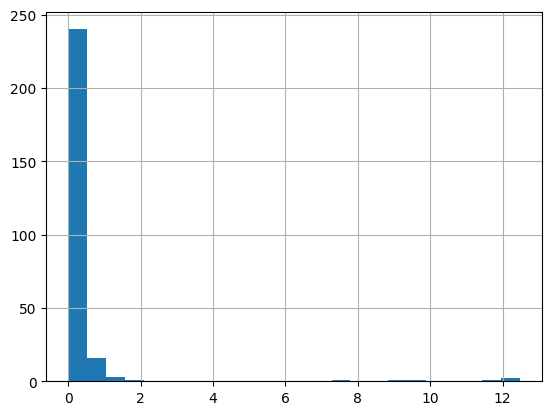

In [8]:
df_transition['Transition_hour'].hist(bins=24)

In [23]:
df.head()

,DATE/TIME,MS,EVENT,TEMPERATURE,EXT TEMPERATURE,ORIENTATION,PIM,PIMn,TAT,TATn,...,F5,F6,F7,F8,MELANOPIC EDI,CLEAR,DATE,TIME,HOUR,Transition
0,2024-01-11 11:17:39+01:00,0,0,22.50,0.0,16,5964,99.4000,193,3.216670,...,0.0412,0.0501,0.0466,0.0382,188.72,0.13,2024-01-11,11:17:39,11.29,True
1,2024-01-11 11:18:39+01:00,0,0,24.06,0.0,8,2288,38.1333,68,1.133330,...,0.0956,0.1101,0.1169,0.1274,534.11,0.37,2024-01-11,11:18:39,11.31,False
2,2024-01-11 11:19:39+01:00,0,0,24.69,0.0,16,2600,43.3333,52,0.866667,...,0.0947,0.1105,0.1141,0.1182,480.84,0.34,2024-01-11,11:19:39,11.33,False
3,2024-01-11 11:20:39+01:00,0,0,25.12,0.0,8,2543,42.3833,42,0.700000,...,0.0841,0.0971,0.1027,0.1111,456.78,0.32,2024-01-11,11:20:39,11.34,False
4,2024-01-11 11:21:39+01:00,0,0,25.31,0.0,16,1170,19.5000,14,0.233333,...,0.0873,0.1025,0.1028,0.1014,445.03,0.31,2024-01-11,11:21:39,11.36,False


In [27]:

# Or if DATE is string, convert column
df['DATE'] = df['DATE'].astype(str)
df_subset = df[df['DATE'].isin(['2024-01-16', '2024-01-17', '2024-01-18'])]


In [29]:
df_subset = df_subset[['DATE/TIME', 'TEMPERATURE', 'PIMn', 'TATn', 'ZCMn', 
                       'MELANOPIC EDI', 'DATE', 'TIME', 'HOUR', 'Transition']].copy()

In [30]:
df_subset.head()

,DATE/TIME,TEMPERATURE,PIMn,TATn,ZCMn,MELANOPIC EDI,DATE,TIME,HOUR,Transition
6523,2024-01-16 00:00:39+01:00,24.56,0.0,0.0,0.0,0.0,2024-01-16,00:00:39,0.01,True
6524,2024-01-16 00:01:39+01:00,24.44,0.0,0.0,0.0,0.0,2024-01-16,00:01:39,0.03,False
6525,2024-01-16 00:02:39+01:00,24.25,0.0,0.0,0.0,0.0,2024-01-16,00:02:39,0.04,False
6526,2024-01-16 00:03:39+01:00,24.19,0.0,0.0,0.0,0.0,2024-01-16,00:03:39,0.06,False
6527,2024-01-16 00:04:39+01:00,24.06,0.0,0.0,0.0,0.0,2024-01-16,00:04:39,0.08,False


In [ ]:
df_subset_Day1 = df_subset[df_subset['DATE'] == '2024-01-16']
# rolling mean
df_subset_Day1['MELANOPIC EDI'] = df_subset_Day1['MELANOPIC EDI'].rolling(window=3).mean()

df_subset_Day2 = df_subset[df_subset['DATE'] == '2024-01-17']
df_subset_Day3 = df_subset[df_subset['DATE'] == '2024-01-18']

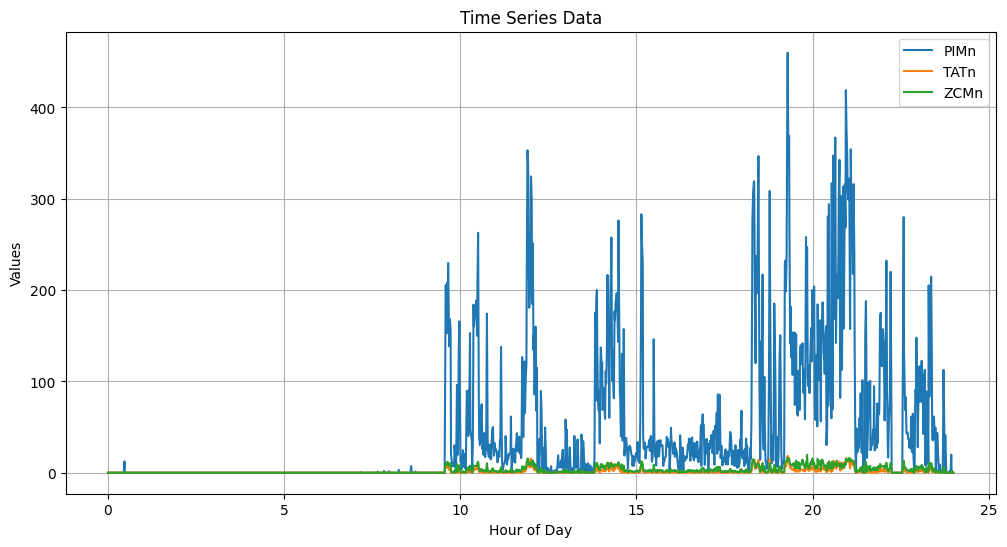

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df_subset_Day1['HOUR'], df_subset_Day1['PIMn'], label='PIMn')
plt.plot(df_subset_Day1['HOUR'], df_subset_Day1['TATn'], label='TATn')
plt.plot(df_subset_Day1['HOUR'], df_subset_Day1['ZCMn'], label='ZCMn')
plt.xlabel('Hour of Day')
plt.ylabel('Values')
plt.title('Time Series Data')
plt.legend()
plt.grid()
plt.show()

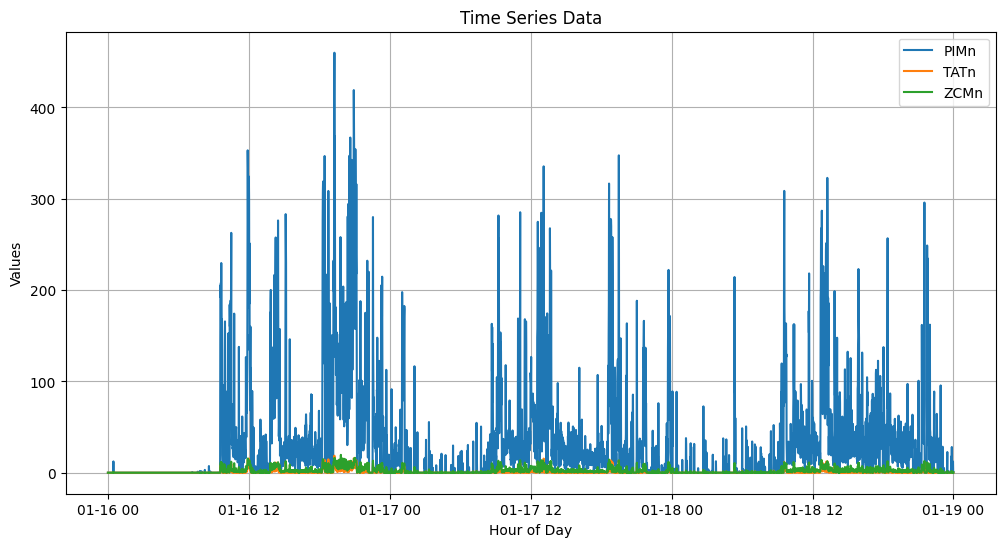

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df_subset['DATE/TIME'], df_subset['PIMn'], label='PIMn')
plt.plot(df_subset['DATE/TIME'], df_subset['TATn'], label='TATn')
plt.plot(df_subset['DATE/TIME'], df_subset['ZCMn'], label='ZCMn')
plt.xlabel('Hour of Day')
plt.ylabel('Values')
plt.title('Time Series Data')
plt.legend()
plt.grid()
plt.show()

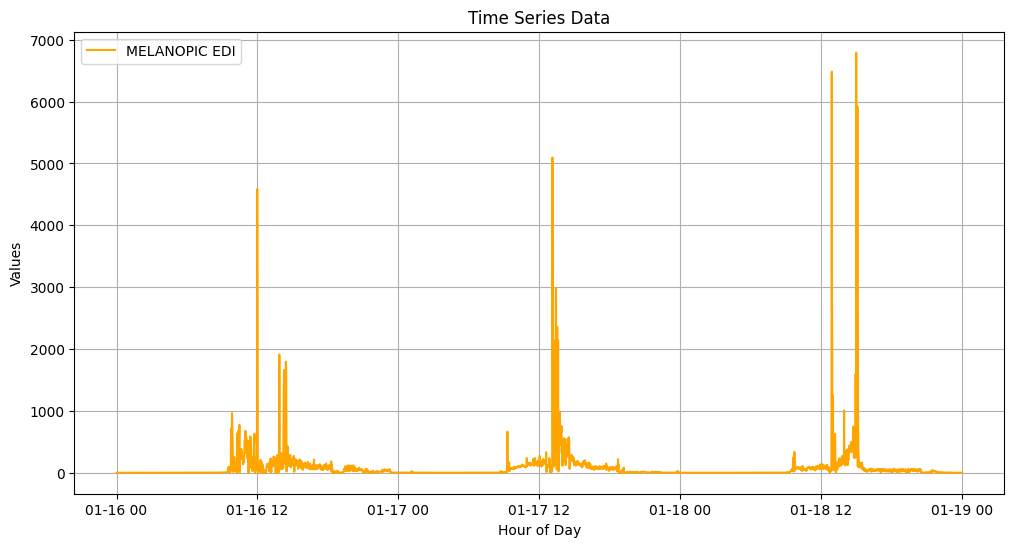

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df_subset['DATE/TIME'], df_subset['MELANOPIC EDI'], label='MELANOPIC EDI', color='orange')
plt.xlabel('Hour of Day')
plt.ylabel('Values')
plt.title('Time Series Data')
plt.legend()
plt.grid()
plt.show()